<center><font size=8>Internet of Things</font></center><br>
<center>* Vous trouverez les commentaires et le cheminement de notre refléxion dans le rapport*</center>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv')

Pair plot on train set


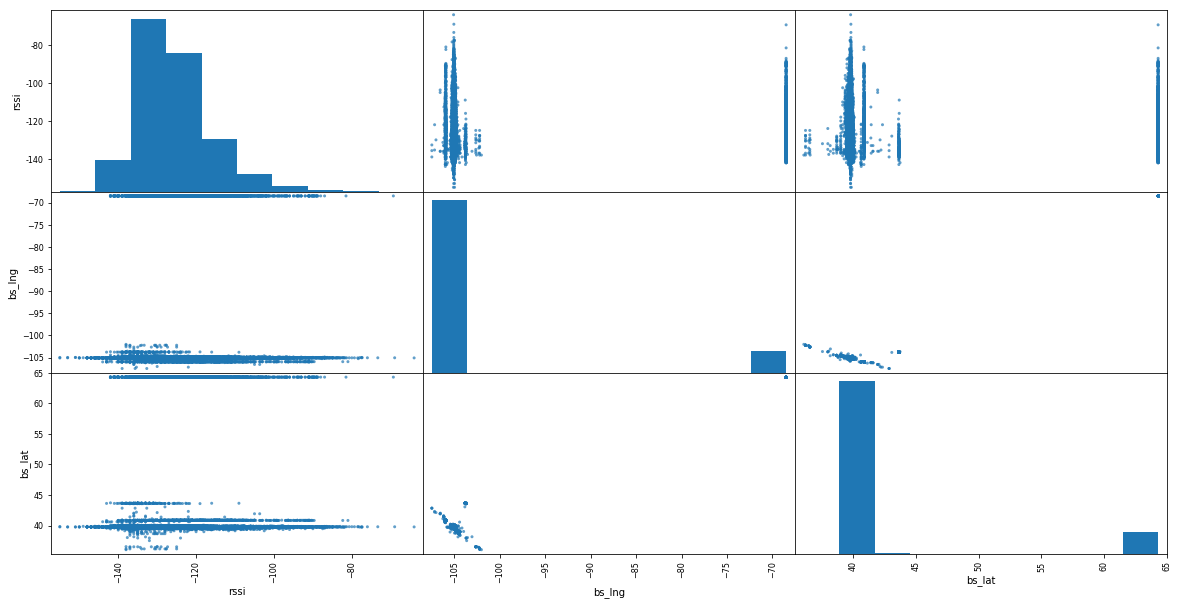

In [3]:
pd.plotting.scatter_matrix(df_mess_train[['rssi', 'bs_lng', 'bs_lat']], alpha=0.7, figsize=(20,10))
print('Pair plot on train set')
plt.show()

Pair plot on test set


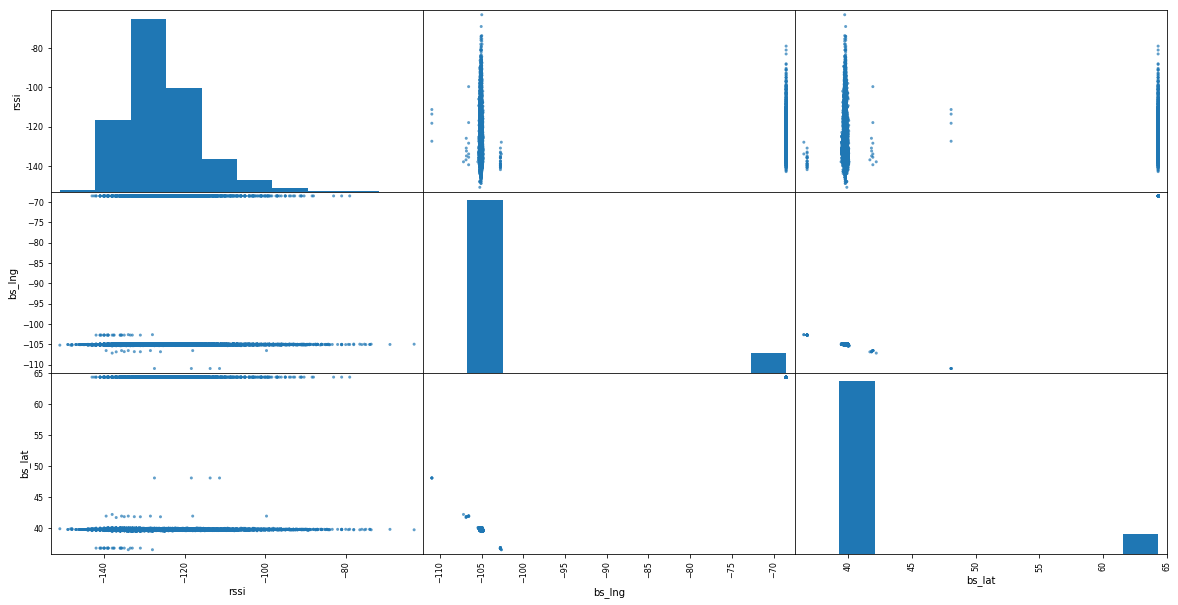

In [5]:
print('Pair plot on test set')
pd.plotting.scatter_matrix(df_mess_test[['rssi', 'bs_lng', 'bs_lat']], alpha=0.7, figsize=(20,10))
plt.show()

## Outlier detection:

In [6]:
total_dataset = pd.concat([df_mess_train, df_mess_test])

In [7]:
%%time
model = DBSCAN(eps=1.5, min_samples=5)
y = model.fit_predict(df_mess_train[['bs_lng', 'bs_lat']])

CPU times: user 17 s, sys: 45.9 s, total: 1min 2s
Wall time: 1min 27s


In [8]:
def convert_color(y):
    if y==0:
        return 'b'
    elif y==1:
        return 'y'
    elif y==2:
        return 'g'
    else:
        return 'r'
    
y_color = list(map(lambda x: convert_color(x), y))

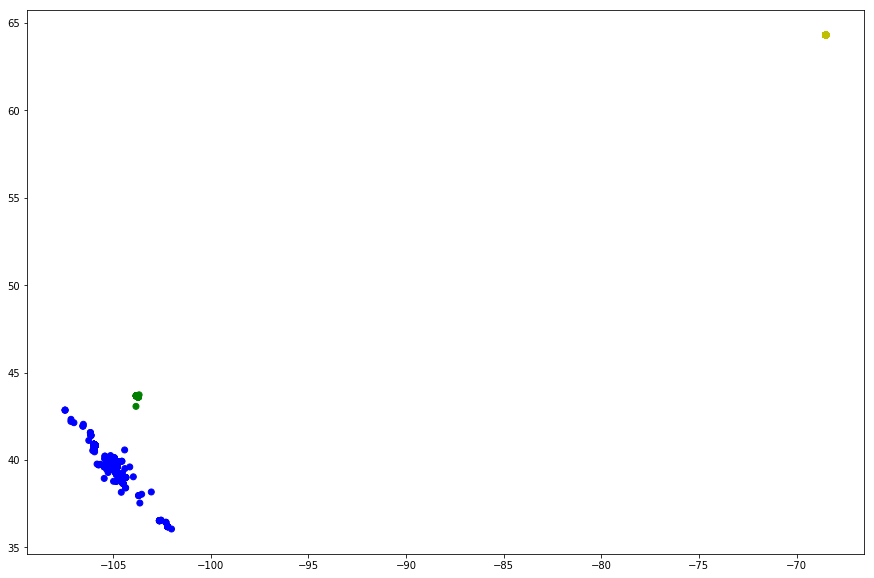

In [9]:
plt.figure(figsize=(15,10))
plt.scatter(df_mess_train['bs_lng'], df_mess_train['bs_lat'], c=y_color[:39250])
plt.show()

[0 1]


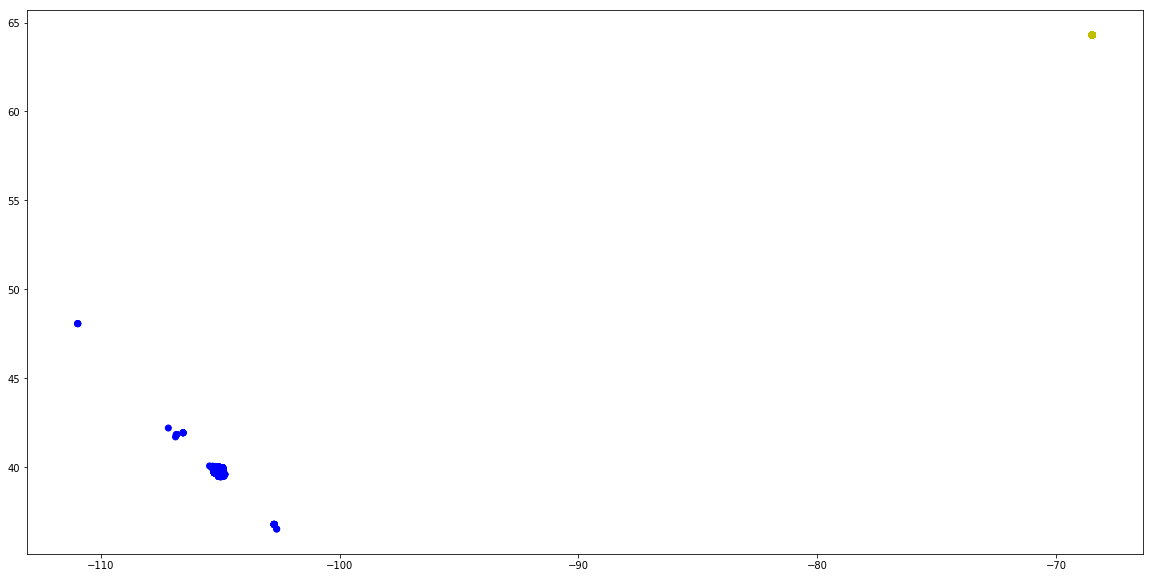

In [10]:
# Plus rapide de faire un KNN simple pour le test que de faire un DBSCAN sur l'ensemble train + test.
knn = KNeighborsClassifier()
knn.fit(df_mess_train[['bs_lng', 'bs_lat']], y)
y_test = knn.predict(df_mess_test[['bs_lng', 'bs_lat']])
#y_test = model.fit_predict(df_mess_test[['bs_lng', 'bs_lat']])
print(np.unique(y_test))
y_test_color = list(map(lambda x: convert_color(x), y_test))
plt.figure(figsize=(20,10))
plt.scatter(df_mess_test['bs_lng'], df_mess_test['bs_lat'], c=y_test_color)
plt.show()

Plotting location of messages


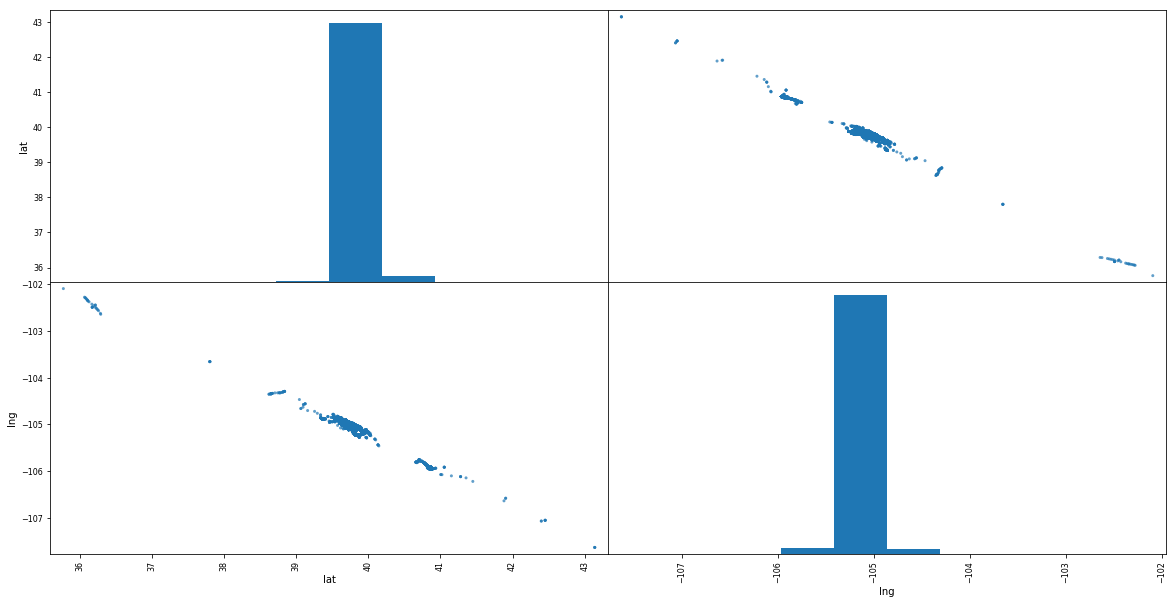

In [11]:
print('Plotting location of messages')
pd.plotting.scatter_matrix(pos_train, alpha=0.7, figsize=(20,10))
plt.show()

Les stations contenant des coordonnées abérentes sont donc:

In [12]:
bsid_weird = np.unique(df_mess_train['bsid'][y == 1])
bsid_weird

array([ 1092,  1594,  1661,  1743,  1772,  1796,  1854,  2293,  2707,
        2943,  4123,  4129,  4156,  4959,  4987,  4993,  7248,  8355,
        8449,  8451,  8560,  9784, 10151, 10162, 10999, 11007, 11951])

## Building Feature

In [13]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid']))

In [14]:

def feat_mat_const(df_mess_train, listOfBs):
    '''
   Change les objects ID en index 0->len(np.unique(df_mess_train['objid']))
   Et regarde à quelle base_ID (colonne) est associée cet objet.
   '''
    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=False)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs)
   
    idx = 0
    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = elmt['rssi'].values
        idx = idx + 1
   
    return df_feat
 
df_feat_rssi = feat_mat_const(df_mess_train, listOfBs)
df_feat_rssi.head()

,879,911,921,944,980,1012,1086,1092,1120,1131,...,9936,9941,9949,10134,10148,10151,10162,10999,11007,11951
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,-141.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def feat_mat_const_lat(df_mess_train, listOfBs):
    '''
   Change les objects ID en index 0->len(np.unique(df_mess_train['objid']))
   Et regarde à quelle base_ID (colonne) est associée cet objet.
   '''
    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=False)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs)
   
    idx = 0
    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = elmt['bs_lat'].values
        idx = idx + 1
   
    return df_feat

def feat_mat_const_long(df_mess_train, listOfBs):
    '''
   Change les objects ID en index 0->len(np.unique(df_mess_train['objid']))
   Et regarde à quelle base_ID (colonne) est associée cet objet.
   '''
    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=False)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs)
   
    idx = 0
    for key, elmt in df_mess_bs_group:
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = elmt['bs_lng'].values
        idx = idx + 1
   
    return df_feat

In [16]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['objid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['objid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng
# ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, df_mess_train[['y_lat', 'y_lng']])
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(6068,)

# Modeling

In [17]:
def dbm_to_mw(dBm):
    return 10**((dBm)/10.)

In [18]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [19]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [20]:
def predict_and_score(df, y_lat, y_long, apply_scaler = True, apply_dbtransform = True, with_coord = True):
    
    if(apply_dbtransform == True):
        df['rssi'] = df['rssi'].apply(dbm_to_mw)
    df_feat_rssi = feat_mat_const(df, listOfBs)
    if(with_coord == True):
        df_feat_long = feat_mat_const_long(df, listOfBs)
        df_feat_lat = feat_mat_const_lat(df, listOfBs)
        
        df_lat = pd.concat([df_feat_rssi, df_feat_lat], axis=1)
        df_long = pd.concat([df_feat_rssi, df_feat_long], axis=1)
    else:
        df_lat = df_feat_rssi
        df_long = df_feat_rssi
    
    if(apply_scaler == True):
        scaler = MaxAbsScaler()
        df_lat = scaler.fit_transform(np.array(df_lat))
        df_long = scaler.fit_transform(np.array(df_long))
    
    
    # fit on latitudes
    model = KNeighborsRegressor(n_neighbors=5, weights='distance')
    model.fit(df_lat, y_lat)
    y_lat_pred = model.predict(df_lat)
    
    # fit on longitudes
    model2 = KNeighborsRegressor(n_neighbors=5, weights='distance')
    model2.fit(df_long, y_long)
    y_long_pred = model2.predict(df_long)
    
    # Conpute error on train set
    err_vec_train = Eval_geoloc(ground_truth_lat , ground_truth_lng,  list(y_lat_pred), list(y_long_pred))
    
    # Compute error with crossval:
    model1 = KNeighborsRegressor(n_neighbors=5, weights='distance')
    model2 = KNeighborsRegressor(n_neighbors=5, weights='distance')
    y_pred_lng = cross_val_predict(model1, df_lat, ground_truth_lng, cv=10)
    y_pred_lat = cross_val_predict(model2, df_long, ground_truth_lat, cv=10)
    err_vec_crossval = Eval_geoloc(ground_truth_lat , ground_truth_lng, list(y_pred_lat), list(y_pred_lng))
    
    # plot error curve:
    values, base = np.histogram(err_vec_crossval, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability Crossval'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
    plt.show()
    
    print("Error train:", np.percentile(err_vec_train, 80))
    print("Error crossval:", np.percentile(err_vec_crossval, 80))
    
    return np.percentile(err_vec_crossval, 80)

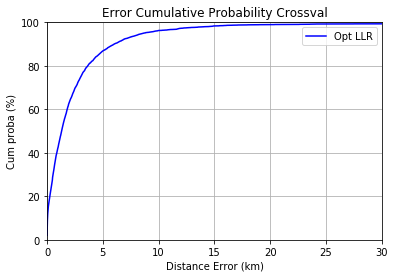

Error train: 0.0
Error crossval: 3652.49839294


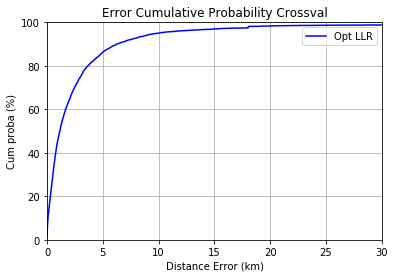

Error train: 0.0
Error crossval: 3673.0789626


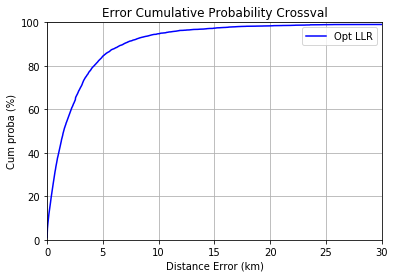

Error train: 0.0
Error crossval: 4217.80478899


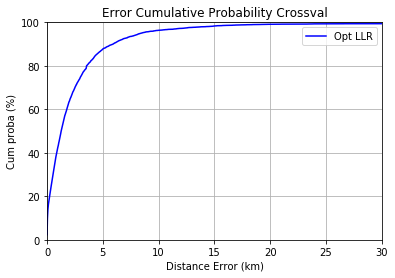

Error train: 0.0
Error crossval: 3556.17361953


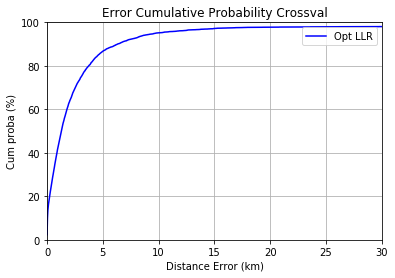

Error train: 0.0
Error crossval: 3745.44482512


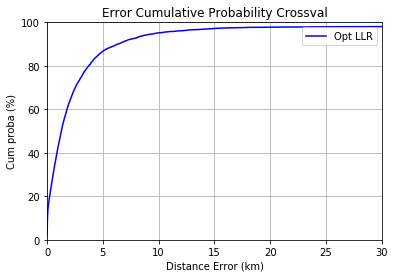

Error train: 0.0
Error crossval: 3739.95150437


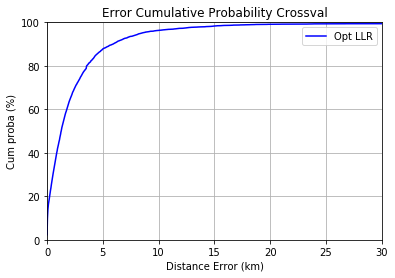

Error train: 0.0
Error crossval: 3566.56726698


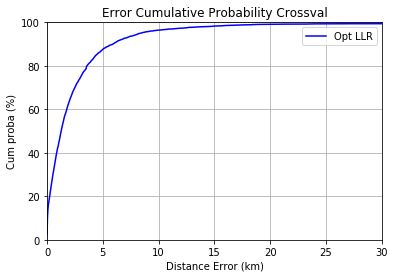

Error train: 0.0
Error crossval: 3577.79478946
CPU times: user 9min 33s, sys: 3.84 s, total: 9min 37s
Wall time: 9min 40s


In [21]:
%%time
with_dbreduce = [False, True, False, True, False, True, False, True]
with_scaler = [False, False, True, True, False, False, True, True]
with_coord = [False, False, False, False, True, True, True, True]
scores = []
for db, sc, coord in zip(with_dbreduce, with_scaler, with_coord):
    scores.append(predict_and_score(df_mess_train, ground_truth_lat, ground_truth_lng,
                                    apply_scaler = sc, apply_dbtransform = db, with_coord = coord))

In [24]:
df_result = pd.DataFrame({'toMW': with_dbreduce, 'Scale': with_scaler, 'Coords':with_coord, 'Scores':scores})
df_result.sort_values(by='Scores')[['Coords', 'Scale', 'toMW', 'Scores']]

,Coords,Scale,toMW,Scores
3,False,True,True,3556.173620
6,True,True,False,3566.567267
7,True,True,True,3577.794789
0,False,False,False,3652.498393
1,False,False,True,3673.078963
5,True,False,True,3739.951504
4,True,False,False,3745.444825
2,False,True,False,4217.804789


# Grid Search

In [25]:
# On applique le scale, la transformation en MW et on utilise les coordonnées des balises:
df_mess_train['rssi'] = df_mess_train['rssi'].apply(dbm_to_mw)
df_feat_rssi = feat_mat_const(df_mess_train, listOfBs)

df_feat_long = feat_mat_const_long(df_mess_train, listOfBs)
df_feat_lat = feat_mat_const_lat(df_mess_train, listOfBs)
        
df_lat = pd.concat([df_feat_rssi, df_feat_lat], axis=1)
df_long = pd.concat([df_feat_rssi, df_feat_long], axis=1)

scaler = MaxAbsScaler()
df_lat = scaler.fit_transform(np.array(df_lat))
df_long = scaler.fit_transform(np.array(df_long))

y_lat = ground_truth_lat
y_long = ground_truth_lng

In [26]:
neighbors = []
result = []
for k in [3, 5, 7, 11]:
    model1 = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model2 = KNeighborsRegressor(n_neighbors=k, weights='distance')
    y_pred_lng = cross_val_predict(model1, df_lat, ground_truth_lng, cv=10)
    y_pred_lat = cross_val_predict(model2, df_long, ground_truth_lat, cv=10)
    err_vec_crossval = Eval_geoloc(ground_truth_lat , ground_truth_lng, list(y_pred_lat), list(y_pred_lng))
    neighbors.append(k)
    result.append(np.percentile(err_vec_crossval, 80))

In [27]:
df_grid = pd.DataFrame({'K':neighbors, 'Score':result})
df_grid

,K,Score
0,3,3797.130160
1,5,3569.921049
2,7,3560.504383
3,11,3534.482341


# Prediction sur le test set

In [28]:
# Processing test set:

df_mess_test['rssi'] = df_mess_test['rssi'].apply(dbm_to_mw)
df_feat_rssi_test = feat_mat_const(df_mess_test, listOfBs)

df_feat_long_test = feat_mat_const_long(df_mess_test, listOfBs)
df_feat_lat_test = feat_mat_const_lat(df_mess_test, listOfBs)
        
df_lat_test = pd.concat([df_feat_rssi_test, df_feat_lat_test], axis=1)
df_long_test = pd.concat([df_feat_rssi_test, df_feat_long_test], axis=1)

scaler = MaxAbsScaler()
df_lat_test = scaler.fit_transform(np.array(df_lat_test))
df_long_test = scaler.fit_transform(np.array(df_long_test))


# Fit model on training set
model_lat = KNeighborsRegressor(n_neighbors=3, weights='distance')
model_lng = KNeighborsRegressor(n_neighbors=3, weights='distance')
model_lat.fit(df_lat, y_lat)
model_lng.fit(df_long, y_long)

# Predict model on test set

y_pred_lng = model_lng.predict(df_long_test)
y_pred_lat = model_lat.predict(df_lat_test)

In [29]:
pos_train_pred = pd.DataFrame({'lat':y_pred_lat, 'lng':y_pred_lng})
pos_train_pred.to_csv('pred_pos_test_list1.csv', index=False)